In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from random import sample
import scipy

import skimage
import pydicom
import glob

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [35]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

sample_df_orig = sample_df.copy()

In [36]:
!find /data -name "00025045_000.png"

/data/images_011/images/00025045_000.png


In [37]:
sample_df.shape

(5606, 11)

In [38]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [39]:
## EDA
# Todo 

# The patient demographic data such as gender, age, patient position,etc. (as it is available)
print("Patient Gender: ")
print(sample_df['Patient Gender'].value_counts(),"\n")

# The x-ray views taken (i.e. view position) 
print("x-ray views taken")
print(sample_df['View Position'].value_counts(),"\n")

print("Number of Diseases/per Patient")
sample_df['NumDiseasePerPatient'] = sample_df['Finding Labels'].str.split("|").str.len()
print(sample_df['NumDiseasePerPatient'].head())

Patient Gender: 
M    3134
F    2472
Name: Patient Gender, dtype: int64 

x-ray views taken
PA    3393
AP    2213
Name: View Position, dtype: int64 

Number of Diseases/per Patient
0    4
1    2
2    1
3    1
4    3
Name: NumDiseasePerPatient, dtype: int64


In [40]:
# list(chain(*sample_df['Finding Labels'].map(lambda x: x.split("|"))))
# list(chain(sample_df['Finding Labels'].map(lambda x: x.split("|"))))


In [41]:
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'NumDiseasePerPatient'],
      dtype='object')

In [42]:
# based on Exploring Population Metadata Exercise SOlution (TO DO)
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split("|")))))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels: 
    if len(c_label) > 1: 
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [43]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Number of disease per patient (TO DO)

print("There are {} unique types of labels found in this dataset".format(len(all_labels)))
print("These are their percentages")
xx = sample_df[all_labels].sum()/len(sample_df)
xx.sort_values(ascending=False)

There are 15 unique types of labels found in this dataset
These are their percentages


No Finding            0.542990
Infiltration          0.172494
Effusion              0.114877
Atelectasis           0.090617
Nodule                0.055833
Mass                  0.050660
Pneumothorax          0.048341
Consolidation         0.040314
Pleural_Thickening    0.031395
Cardiomegaly          0.025152
Emphysema             0.022654
Edema                 0.021049
Fibrosis              0.014984
Pneumonia             0.011060
Hernia                0.002319
dtype: float64

In [45]:
print("Number of disease/patient")

sample_df[all_labels].sum(axis=1)

Number of disease/patient


0       4.0
1       2.0
2       1.0
3       1.0
4       3.0
       ... 
5601    1.0
5602    3.0
5603    1.0
5604    1.0
5605    1.0
Length: 5606, dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

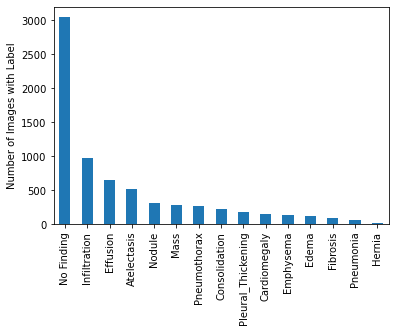

In [46]:
ax = sample_df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

A plot of the relative frequencies of each disease in our dataset is shown above. Please note that 'No Finding' is the most common occurrence (54.30%). 'No Finding' can never appear with any other label by definition, so we know that in 54.30% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

Since 'Infiltration' is the most common, I'm going to now look at how frequently it appears with all of the other diseases:

[Text(0, 0.5, 'Number of Images with Label')]

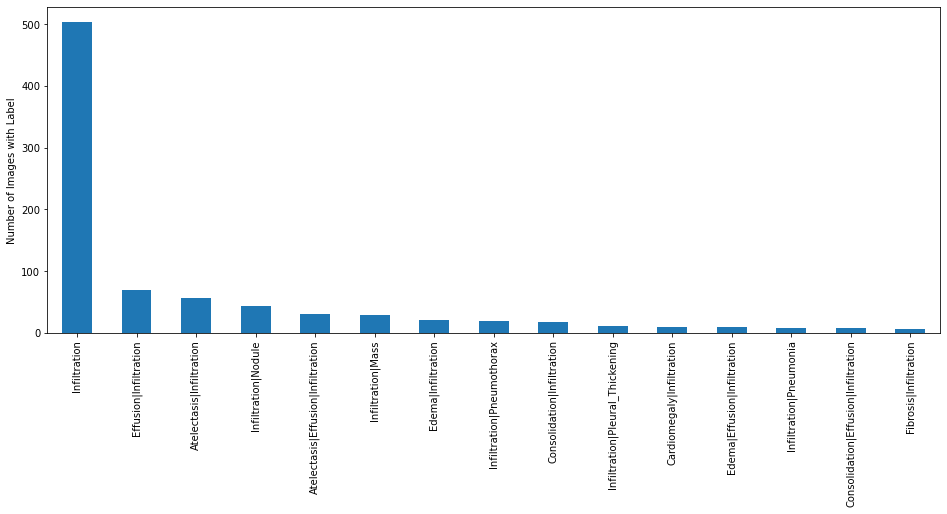

In [47]:
plt.figure(figsize=(16,6))
sample_df_Infiltration = sample_df[sample_df.Infiltration == 1]
ax = sample_df_Infiltration['Finding Labels'].value_counts().sort_values(ascending=False)[0:15].plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

It looks the `Infiltration` is the common occurrence, followed by Effusion. We could try another disease and study the distribution of comorbities. For this time let us pick the third commond disease, Effusion. 

[Text(0, 0.5, 'Number of Images with Label')]

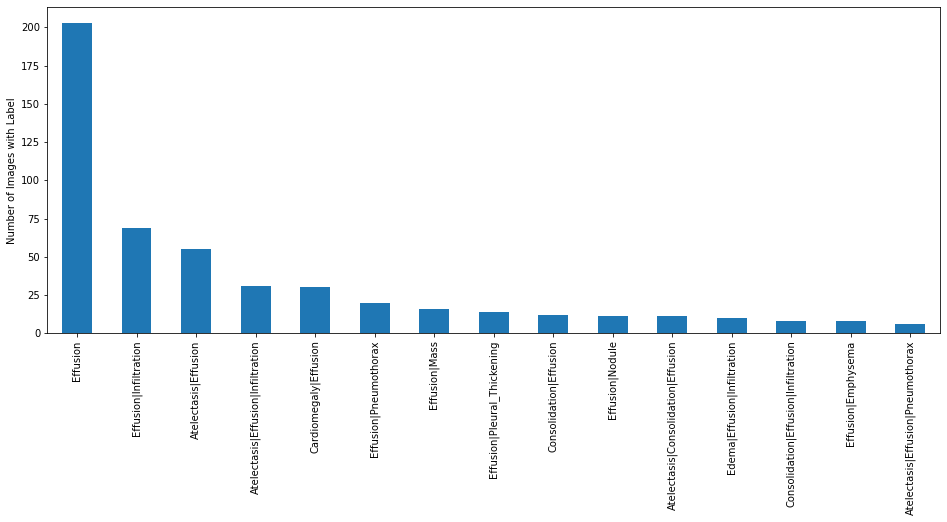

In [48]:
plt.figure(figsize=(16,6))
sample_df_Effusion = sample_df[sample_df.Effusion == 1]
ax = sample_df_Effusion['Finding Labels'].value_counts().sort_values(ascending=False)[0:15].plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The results are the same as the previous two data subsets.

In [49]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# import re
# def remove_non_numbers(s):
#     return re.sub('[^0-9]+', '', s)

In [51]:
sample_df['Patient Age'].replace(r'[a-zA-Z%]', '', regex=True, inplace=True)
# sample_df['Patient Age'] = sample_df['Patient Age'].apply(remove_non_numbers)
# sample_df['Patient Age'] = sample_df['Patient Age'].str.replace(regex=[r'\D+'],value="")
sample_df['Patient Age'] = sample_df['Patient Age'].astype('float')

In [52]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60.0,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57.0,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,77.0,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,79.0,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55.0,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
sample_df_orig.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [54]:
sample_df['Patient Age'].value_counts()

58.0     167
54.0     158
55.0     152
57.0     148
51.0     147
        ... 
88.0       1
1.0        1
94.0       1
411.0      1
86.0       1
Name: Patient Age, Length: 91, dtype: int64

In [55]:
sample_df_orig['Patient Age'].value_counts()

058Y    167
054Y    158
055Y    152
057Y    148
051Y    147
       ... 
001D      1
088Y      1
086Y      1
411Y      1
094Y      1
Name: Patient Age, Length: 92, dtype: int64

In [56]:
sample_df_orig[sample_df_orig['Patient Age'].str.find("M") == 3]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
3865,00019045_003.png,Infiltration,3,19045,013M,F,PA,1562,1001,0.143,0.143


In [57]:
sample_df_orig[sample_df_orig['Patient Age'].str.find("D") == 3]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4749,00024680_000.png,No Finding,0,24680,001D,M,PA,2734,2991,0.143,0.143


Note the following patient's age is 411Y. 

```
	      ImageIndex	  Finding Labels	Follow-up #	Patient ID	Patient Age	Patient Gender
4242	00020900_002.png	No Finding	       2	      20900	      411Y	          M

```

Change the following two patient's age 1D and 13M in terms of years just like the rest of the patients. 
Note, I have converted the string type for this variable (`Patient Age`) to a `float` datatype.

In [58]:
print(sample_df_orig.iloc[4749, sample_df_orig.columns.get_loc('Patient Age')])  
print(sample_df_orig.iloc[3865, sample_df_orig.columns.get_loc('Patient Age')])

001D
013M


In [59]:
print(sample_df.iloc[4749, sample_df_orig.columns.get_loc('Patient Age')])  
print(sample_df.iloc[3865, sample_df_orig.columns.get_loc('Patient Age')])

1.0
13.0


In [60]:
sample_df.iloc[4749, sample_df.columns.get_loc('Patient Age')] = 0.003 
sample_df.iloc[3865, sample_df.columns.get_loc('Patient Age')] = 1.083 

Changing the patient (index # 4242) from 411Y to 100. This is an approximation.

In [61]:
sample_df.iloc[4242, sample_df.columns.get_loc('Patient Age')] = 100 

In [62]:
sample_df[sample_df.index == 4242]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4242,00020900_002.png,No Finding,2,20900,100.0,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


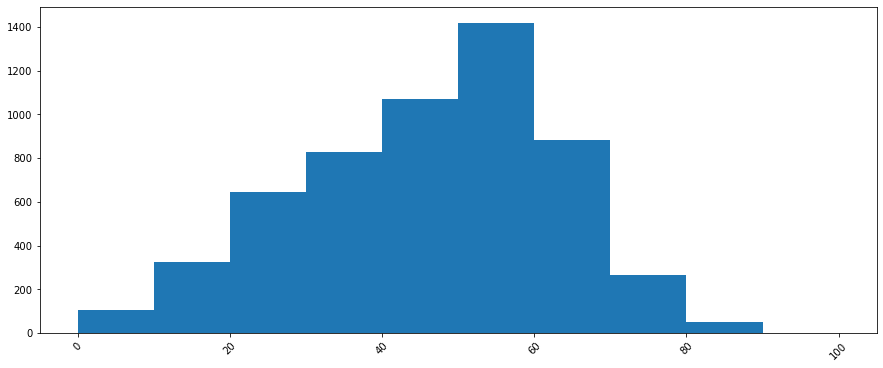

In [63]:
plt.figure(figsize=(15,6))
plt.hist(sample_df['Patient Age']);
plt.xticks(rotation='45');

In [64]:
sample_df[sample_df.index == 4749]
# sample_df[sample_df.index == 3865]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4749,00024680_000.png,No Finding,0,24680,0.003,M,PA,2734,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


(array([ 20.,  45., 101., 114., 142., 156., 211., 135.,  33.,  10.]),
 array([ 1.083 ,  9.8747, 18.6664, 27.4581, 36.2498, 45.0415, 53.8332,
        62.6249, 71.4166, 80.2083, 89.    ]),
 <a list of 10 Patch objects>)

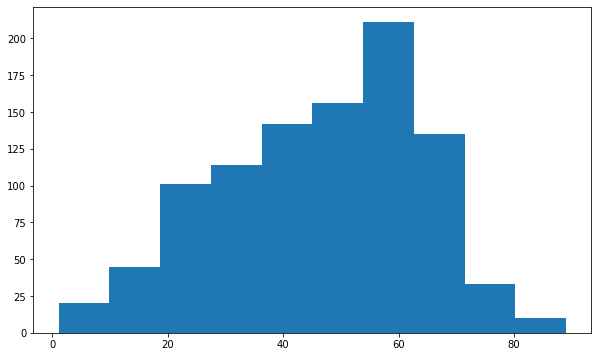

In [65]:
plt.figure(figsize=(10,6))
plt.hist(sample_df[sample_df.Infiltration==1]['Patient Age'])

(array([ 11.,  29.,  48.,  51.,  73.,  94., 146., 116.,  52.,  24.]),
 array([ 6. , 13.7, 21.4, 29.1, 36.8, 44.5, 52.2, 59.9, 67.6, 75.3, 83. ]),
 <a list of 10 Patch objects>)

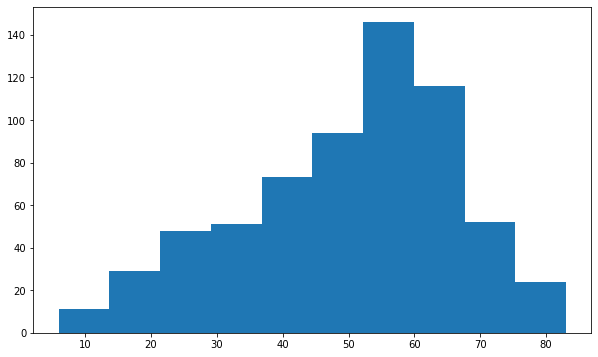

In [66]:
plt.figure(figsize=(10,6))
plt.hist(sample_df[sample_df.Effusion==1]['Patient Age'])

Both the above distributsions are left-skewed.

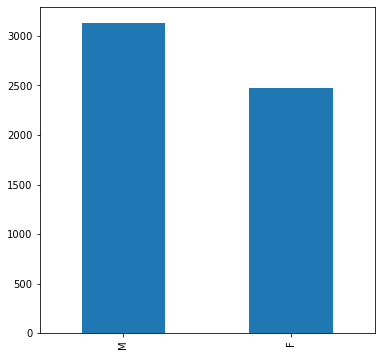

In [67]:
plt.figure(figsize=(6,6))
sample_df['Patient Gender'].value_counts().plot(kind='bar', )
plt.xticks(rotation='90');

In [68]:
sample_df['Patient Gender'].value_counts(normalize=True)

M    0.559044
F    0.440956
Name: Patient Gender, dtype: float64

Note the data is imbalanced on Gender. Number of Male is more than Females (56% to 44%).

Let us look at the Gender distribution for patients with `Infilteration` condition

In [69]:
sample_df[sample_df.Infiltration == 1]['Patient Gender'].value_counts(normalize=True)

M    0.563599
F    0.436401
Name: Patient Gender, dtype: float64

The Gender distribution is the same for patients with `Infilteration` condition as the general population. 

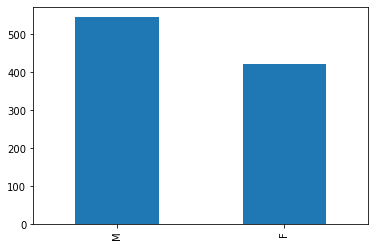

In [70]:
sample_df[sample_df.Infiltration == 1]['Patient Gender'].value_counts().plot(kind='bar')

Let us also compare the gender distribution for people with `Effusion` condition.

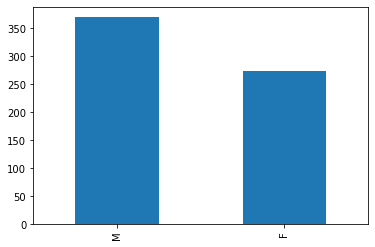

In [71]:
sample_df[sample_df.Effusion == 1]['Patient Gender'].value_counts().plot(kind='bar')

The View Position Attribute is either PA: Posterior/Anterior or AP: Anterior/Posterior

In [72]:
sample_df['View Position'].value_counts()

PA    3393
AP    2213
Name: View Position, dtype: int64

Based on the comparisons, it is clear the gender distribution is unbalanced towards Male. 

In [73]:
sample_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'NumDiseasePerPatient', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [74]:
!du -hs *


2.2M	Build and train model.ipynb
24K	EDA.ipynb
12K	FDA_Submission_Template.md
12K	Inference.ipynb
16K	my_model.json
428K	sample_labels.csv
1.1M	test1.dcm
1.1M	test2.dcm
1.1M	test3.dcm
1.1M	test4.dcm
1.1M	test5.dcm
1.1M	test6.dcm
820K	test_del.csv
157M	xray_class_my_model.best.hdf5


Let us compare how `Patient Age` and `Patient Gender` relate to Patients who have a `Mass` 

In [75]:
# sample_df.groupby('Mass', 'Patient Gender')
xx = sample_df.groupby(by=["Mass", 'Patient Gender'])[all_labels].sum()
xx

Atelectasis  Cardiomegaly  Consolidation  Edema  \
Mass Patient Gender                                                    
0.0  F                     178.0          70.0           91.0   59.0   
     M                     304.0          65.0          107.0   54.0   
1.0  F                       9.0           3.0           11.0    2.0   
     M                      17.0           3.0           17.0    3.0   

                     Effusion  Emphysema  Fibrosis  Hernia  Infiltration  \
Mass Patient Gender                                                        
0.0  F                  251.0       49.0      42.0     4.0         398.0   
     M                  339.0       65.0      36.0     6.0         515.0   
1.0  F                   23.0        2.0       1.0     2.0          24.0   
     M                   31.0       11.0       5.0     1.0          30.0   

                      Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
Mass Patient Gender                                                             
0.0  F                 0.0      1343.0   120.0                65.0       30.0   
     M                 0.0      1701.0   149.0                88.0       28.0   
1.0  F               115.0         0.0    20.0                13.0        3.0   
     M               169.0         0.0    24.0                10.0        1.0   

                     Pneumothorax  
Mass Patient Gender                
0.0  F                      121.0  
     M                      116.0  
1.0  F                       17.0  
     M                       17.0

For the `Mass` classes, comorbidity distribution remains imbalanced, and favored towards `Male or M` 

In [76]:
## First, read all of my DICOM files into a list
mydicoms = glob.glob("*.dcm")

In [77]:
mydicoms

['test5.dcm', 'test4.dcm', 'test6.dcm', 'test2.dcm', 'test3.dcm', 'test1.dcm']

Let us look at the contents of the first DICOM file 

In [78]:
dcm1 = pydicom.dcmread(mydicoms[0])

In [79]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

From the DCM file, we can extract the following attributes: 
* Modality
* Study Description
* Patient ID
* Patient's Sex
* Patient's Age
* Rows
* Columns

We can access DCM's features using the `dot` method

In [80]:
dcm1.Modality

'CT'

In [81]:
dcm1.PatientID

'2'

In [82]:
dcm1.PatientAge

'81'

In [83]:
dcm1.Rows

1024

In [84]:
dcm1.Columns

1024

In [85]:
dcm4 = pydicom.dcmread(mydicoms[3])

In [86]:
dcm4

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.153751009835107614666834563294684339746480
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Cardiomegaly'
(0010, 0020) Patient ID                          LO: '1'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '58'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'AP'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.111396399361969898205364400549799252857604
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.195628213694300498946760767481291263511724
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows     

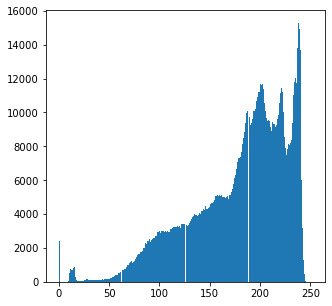

In [87]:
plt.figure(figsize=(5,5))
plt.hist(dcm1.pixel_array.ravel(), bins=256);

The above figure is the distribution of non-disease. Let us compute the mean and sd, and scale the image. 

In [88]:
mean_intensity = np.mean(dcm1.pixel_array)
print("mean_intensity of a No_Finding", mean_intensity)

std_intensity = np.std(dcm1.pixel_array)
print("std_intensity of a No_Finding", std_intensity)


mean_intensity of a No_Finding 180.0586576461792
std_intensity of a No_Finding 47.89115072730743


In [89]:
dcm1_new = dcm1.pixel_array.copy()
dcm1_new = (dcm1_new - mean_intensity)/std_intensity

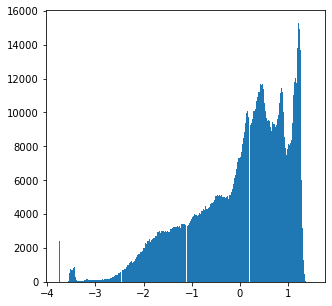

In [90]:
plt.figure(figsize=(5,5))
plt.hist(dcm1_new.ravel(), bins=256);

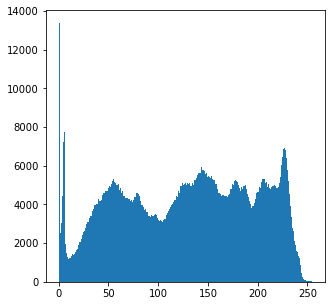

In [91]:
plt.figure(figsize=(5,5))
plt.hist(dcm4.pixel_array.ravel(), bins=256);

In [92]:
mean_intensity = np.mean(dcm4.pixel_array)
print("mean_intensity of a Cardiomegaly", mean_intensity)

std_intensity = np.std(dcm4.pixel_array)
print("std_intensity of a Cardiomegaly", std_intensity)


mean_intensity of a Cardiomegaly 128.13570880889893
std_intensity of a Cardiomegaly 67.42323200014457


In [93]:
dcm4_new = dcm4.pixel_array.copy()
dcm4_new = (dcm4_new - mean_intensity)/std_intensity

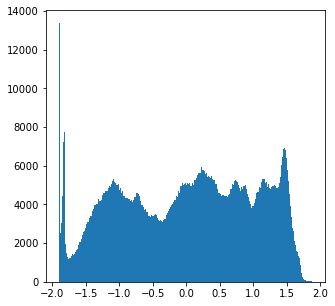

In [94]:
plt.figure(figsize=(5,5))
plt.hist(dcm4_new.ravel(), bins=256);

In [95]:
data_sample = pd.read_csv('/data/Data_Entry_2017.csv')
data_sample_paths = {os.path.basename(x): x for x in 
                     glob.glob(os.path.join('/data','images*', '*', '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)

In [96]:
data_sample

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,/data/images_012/images/00030804_000.png


In [97]:
sample_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,60.0,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,57.0,M,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,77.0,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,79.0,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55.0,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
## This code output will be used in inference 
imgs = []
for i in range(100, 125, 1):
#     print(data_sample['path'])
    img = plt.imread(data_sample['path'][i])
    imgs.append(img)
    
img_mean = np.mean(imgs)
img_std = np.std(imgs)

In [99]:
print(img_mean)
print(img_std)

0.5922315
0.23761849
